# Dataset ARPAE
Registrazione delle misure recuperate dal database ARPAE

In [1]:
setwd(fs::path_abs("~/Local_Workspace/TesiMag"))
library(arrow, warn.conflicts = FALSE)
library(dplyr, warn.conflicts = FALSE)
library(ggplot2, warn.conflicts = FALSE)
library(tsibble, warn.conflicts = FALSE)
library(zeallot, warn.conflicts = FALSE)
library(sf, warn.conflicts = FALSE)
library(tidyr, warn.conflicts = FALSE)
library(assertr, warn.conflicts = FALSE)
library(rlang, warn.conflicts = FALSE)
options(repr.plot.width = 9, repr.plot.res = 300)

source("notebooks/integrazioni_regionali/nb_tools/state_avail.R")
source("notebooks/integrazioni_regionali/nb_tools/pairing_procedure.R")
source("src/load/load.R")
source("src/analysis/data/clim_availability.R")
source("src/analysis/data/quality_check.R")
source("src/pairing/analysis.R")
source("src/pairing/matching.R")
source("src/pairing/plots.R")
source("src/pairing/combining.R")
source("src/pairing/displaying.R")
source("src/plot/plot_helpers.R")
source("src/database/write.R")
source("src/database/open.R")

first_date <- as.Date("2000-01-01")
last_date <- as.Date("2022-12-31")


Linking to GEOS 3.11.0, GDAL 3.5.3, PROJ 9.1.0; sf_use_s2() is TRUE

terra 1.7.55

Caricamento del pacchetto richiesto: abind



In [2]:
dataset_id <- "ARPAE"
state <- "Emilia-Romagna"
path.er.base <- file.path(path.ds, "ARPA", "EMILIA-ROMAGNA")
path.er.meta <- file.path(path.er.base, "metadata.parquet")
path.er.input_ds <- file.path(path.er.base, "tables")
path.er.data <- file.path(path.er.base, "dataset")


## Caricamento da frammenti

In [3]:
ds <- open_dataset(path.er.input_ds, format = "feather") |>
    mutate(station_name = cast(name, utf8()), network = cast(network, utf8()), date = date - as.difftime(agg_period, unit = "secs")) |>
    select(!c(P1, starts_with("level"), name))


In [4]:
ds |>
    slice_head(n = 5) |>
    collect()


lon,lat,elevation,WMO_block,WMO_num,network,date,T,variable,agg_period,station_name
<int>,<int>,<dbl>,<int>,<int>,<chr>,<dttm>,<dbl>,<int>,<int>,<chr>
1050865,4447562,580,NA,NA,agrmet,2006-01-01 00:00:00,269.65,0,3600,Carpineti
1050865,4447562,580,NA,NA,agrmet,2005-12-31 01:00:00,271.07,0,86400,Carpineti
1050865,4447562,580,NA,NA,agrmet,2006-01-01 00:00:00,269.75,2,3600,Carpineti
1050865,4447562,580,NA,NA,agrmet,2005-12-31 01:00:00,273.95,2,86400,Carpineti
1050865,4447562,580,NA,NA,agrmet,2006-01-01 00:00:00,269.55,3,3600,Carpineti


## Metadati
Produco le tabelle dei metadati del dataset e delle stazioni. Controllo con `assertr` e `tsibble` la consistenza delle tabelle.

### Dataset
| dataset_id | entity | reference | 
|------------|--------|-----------|
| utf8()     | utf8() | utf8()    |
| pkey       | obs    | obs       |

### Stazioni
| station_id | station_name | network | geometa |additional_meta | dataset_id | original_id |
|------------|--------------|---------|---------|----------------|------------|-------------|
| utf8()     | utf8()       | utf8()  |         | utf8()         | utf8()     | utf8()      |
| pkey       | obs          | obs     | obs     | fkey           | fkey       | obs         |

I metadati delle stazioni che non rientrano nelle tabelle elencate vanno in una tabella "additional_meta" alla quale puntare con un riferimento

### Serie
| series_id | station_id  | variable | qc_step | merged_from |
|-----------|-------------|----------|---------|-------------|



In [5]:
distinct(ds, station_name, network, lon, lat, elevation, WMO_block, WMO_num) |>
    mutate(lon = lon / 100000, lat = lat / 100000) |>
    collect() |>
    mutate(original_id = str_c(network, station_name, elevation, sep = "/") |> sapply(hash) |> unname(), state = "Emilia-Romagna") |>
    assert(is_uniq, original_id)


In [6]:
write_station_metadata(stations_table, dataset_id)


In [5]:
stations_table <- read_station_metadata(dataset_id)


## Dati
Produco la tabella delle misure. Il formato è row-records:

|series_id|date|value|merged|
|---------|----|-----|------|
|utf8()|date()|float()|bool()|
| fkey    |obs | obs | obs  |

Note:
- `merged` indica se il valore in riga è risultato di un merge. Le caratteristiche del merge sono riportate nella tabella delle stazioni.

Effettuare controllo qualità

In [15]:
ds |>
    left_join(select(stations_table, network, station_name, elevation, station_id), by = join_by(network, station_name, elevation)) |>
    mutate(T = T - 273.15) |>
    gross_errors_check(T) |>
    group_by(station_id, date = as.Date(date)) |>
    summarise(T_MIN = min(T, na.rm = TRUE), T_MAX = max(T, na.rm = TRUE), qc_gross = any(qc_gross)) |>
    ungroup() |>
    filter(!qc_gross) |>
    arrange(station_id, date) |>
    collect() |>
    pivot_longer(c(T_MIN, T_MAX), names_to = "variable") |>
    arrange(variable, station_id, date) |>
    as_tsibble(key = c(station_id, variable), index = date) |>
    repeated_values_check() |>
    filter(!qc_repeated) |>
    select(!starts_with("qc")) |>
    as_tibble() |>
    write_dataset(path.er.data, format = "parquet", partitioning = "variable")


In [6]:
open_dataset(path.er.data) |>
    collect() |>
    as_tsibble(key = c(station_id, variable), index = date) |>
    distinct(station_id, variable) |>
    mutate(qc_step = 1) |>
    as_tibble() |>
    write_series_metadata(dataset_id)


In [7]:
series_table <- read_series_metadata(dataset_id)


In [9]:
open_dataset(path.er.data) |>
    left_join(series_table |> select(station_id, series_id, variable), by = c("station_id", "variable")) |>
    select(series_id, date, value) |>
    mutate(merged = FALSE, value = cast(value, float())) |>
    write_data(dataset_id)


In [10]:
data <- open_data(dataset_id)


## Analisi disponibilità dati
Grafici che mostrano la disponibilità di serie mese per mese

In [12]:
buffer <- load.italian_boundaries("state") |>
    filter(shapeName == state) |>
    st_buffer(dist = units::set_units(10, "km"))
c(scia_station_meta, scia_series_meta) %<-% load_scia_metadata(buffer)
scia_data <- load_scia_data(scia_series_meta)


Reading layer `geoBoundaries-ITA-ADM1' from data source 
  `/Users/davidenicoli/Local_Workspace/Datasets/geoBoundaries/ITA-ADM1/geoBoundaries-ITA-ADM1.geojson' 
  using driver `GeoJSON'
Simple feature collection with 20 features and 5 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 6.626621 ymin: 35.49285 xmax: 18.52038 ymax: 47.09178
Geodetic CRS:  WGS 84


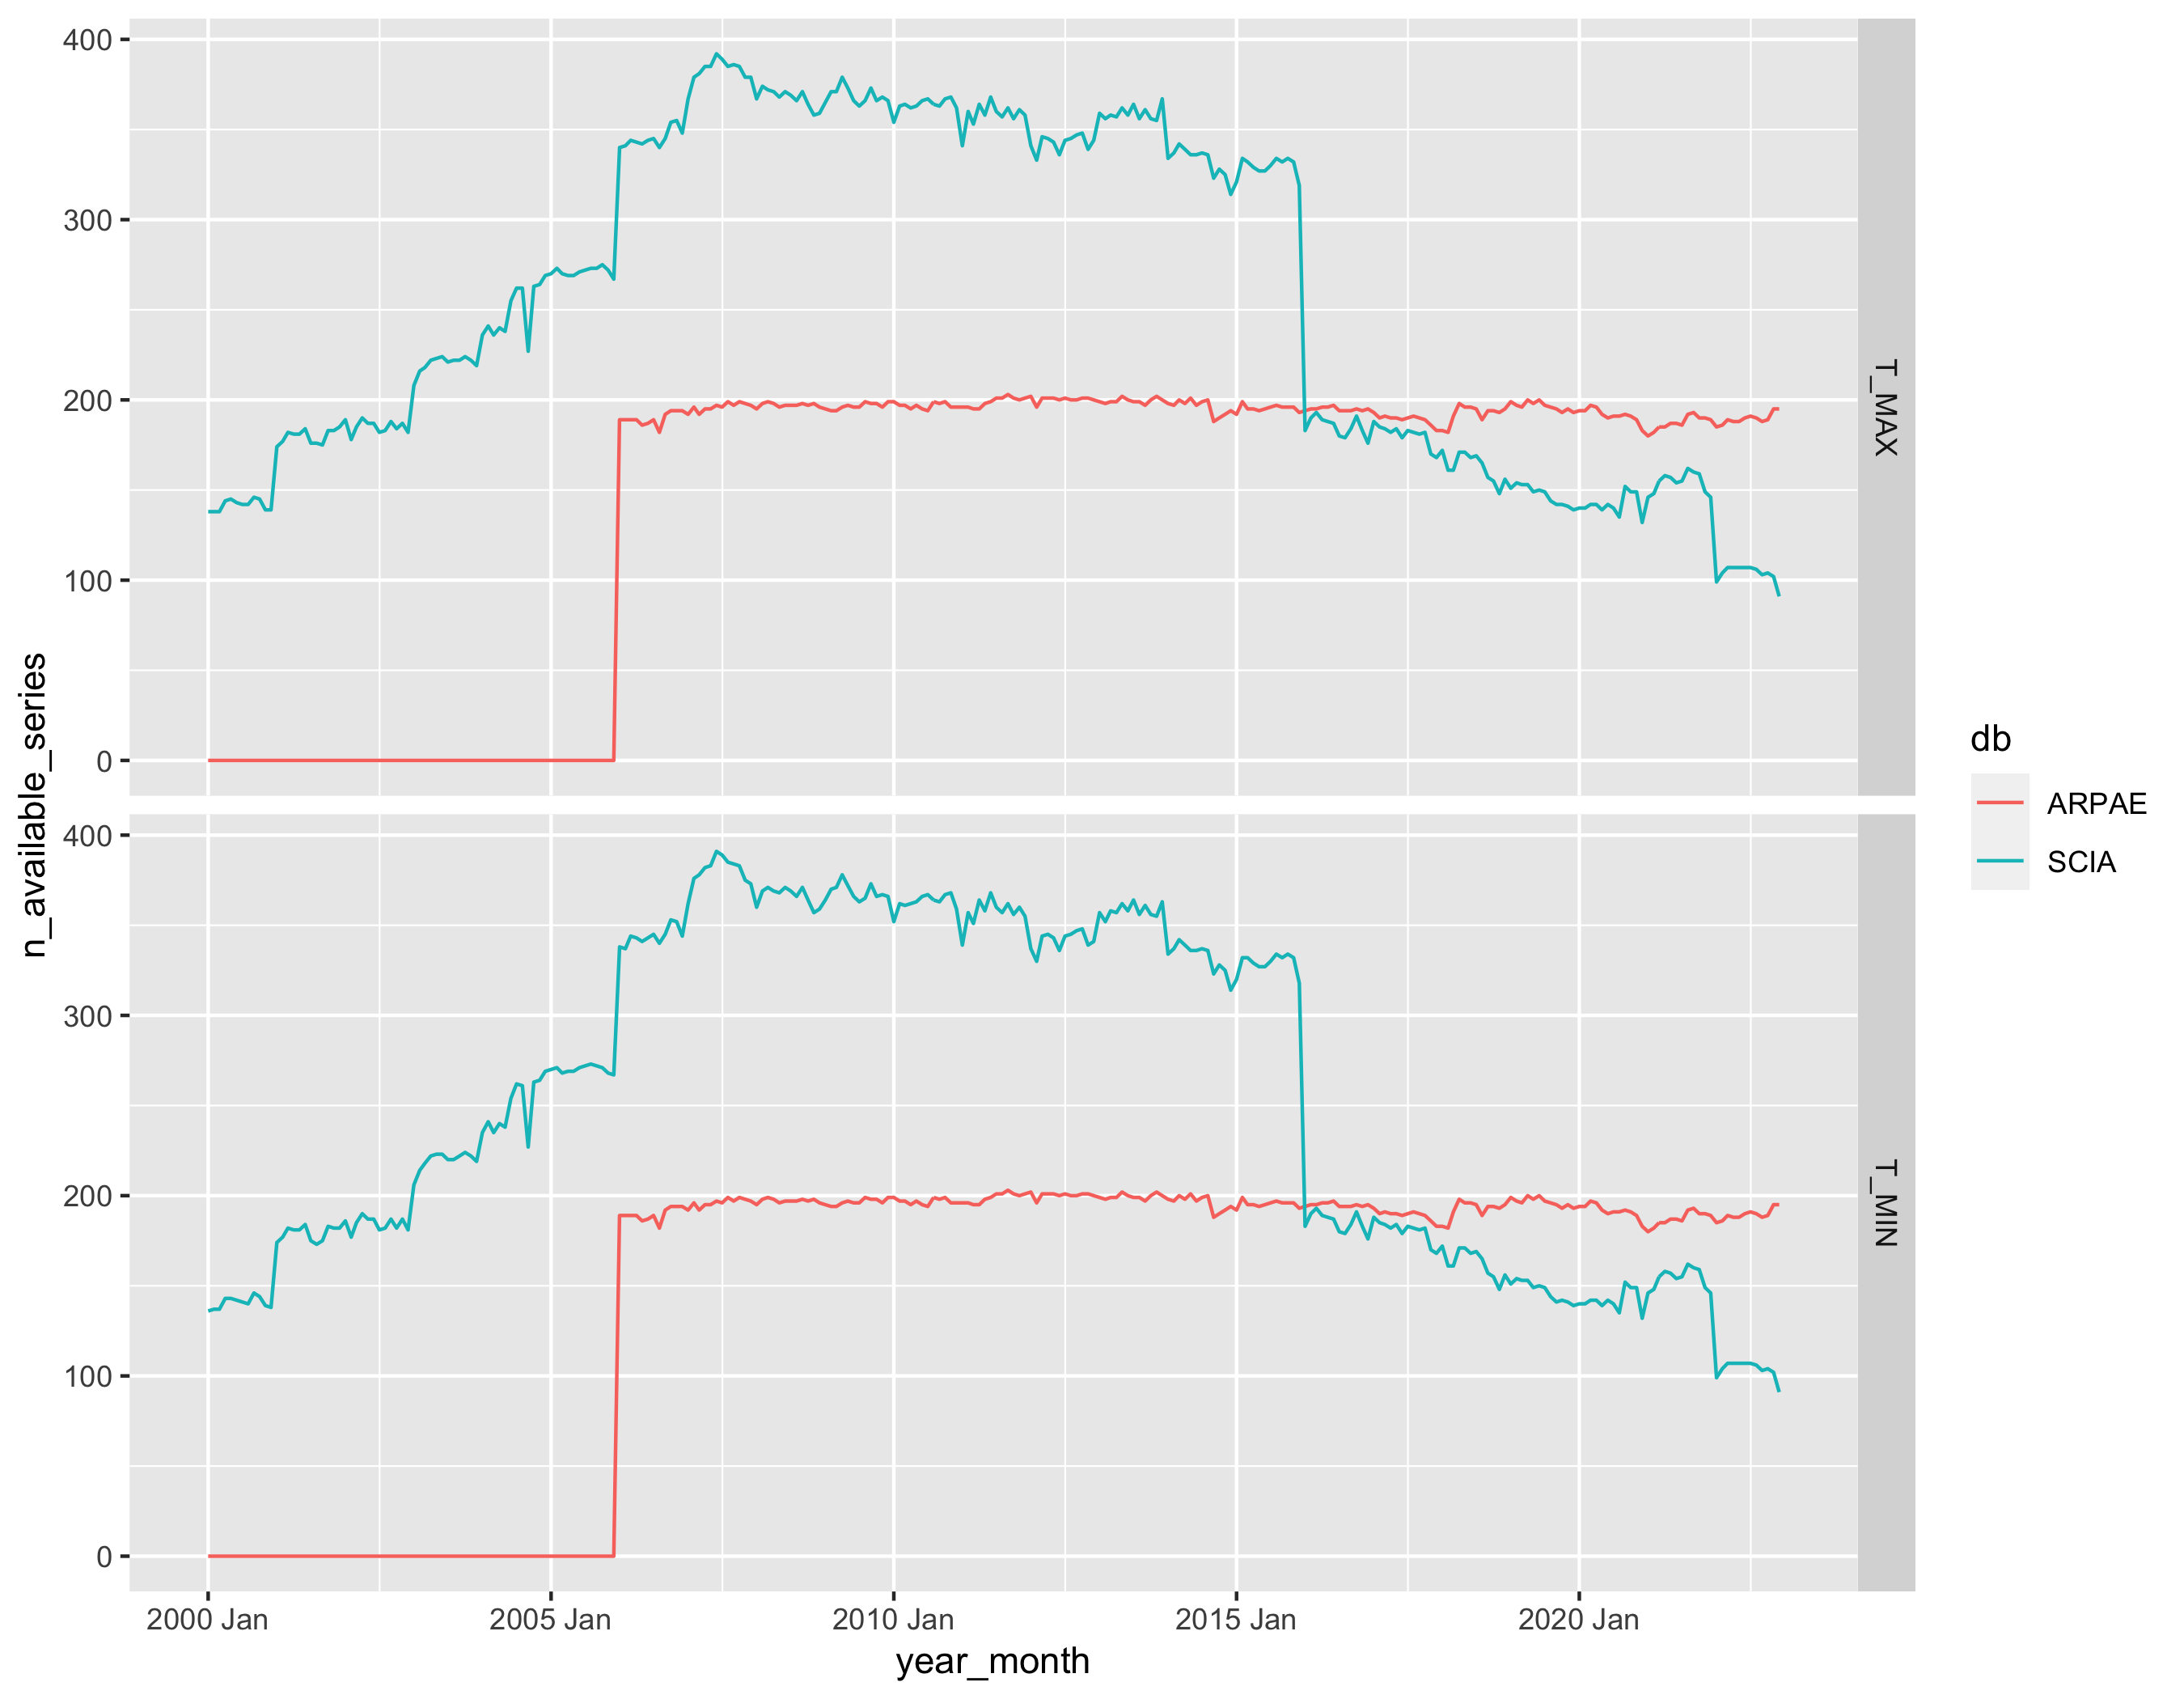

In [44]:
arpae_data <- data |>
    left_join(series_table |> select(series_id, station_id, variable), by = "series_id") |>
    collect() |>
    rename(identifier = station_id) |>
    mutate(db = dataset_id) |>
    select(db, identifier, variable, date, value)
arpae_data |>
    bind_rows(scia_data |> mutate(db = "SCIA") |> rename(identifier = station_id) |> select(db, identifier, variable, date, value) |> collect()) |>
    plot_state_avail(first_date, last_date)


In [51]:
er.boundaries <- load.italian_boundaries("state") |> filter(shapeName == "Emilia-Romagna")
climats_comp <- is_climatology_computable(as_tsibble(arpae_data, key = c(identifier, variable), index = date), value, .start = first_date, .end = last_date) |>
    left_join(stations_table |> select(station_id, lon, lat) |> collect(), by = join_by(identifier == station_id)) |>
    st_md_to_sf()


Reading layer `geoBoundaries-ITA-ADM1' from data source 
  `/Users/davidenicoli/Local_Workspace/Datasets/geoBoundaries/ITA-ADM1/geoBoundaries-ITA-ADM1.geojson' 
  using driver `GeoJSON'
Simple feature collection with 20 features and 5 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: 6.626621 ymin: 35.49285 xmax: 18.52038 ymax: 47.09178
Geodetic CRS:  WGS 84


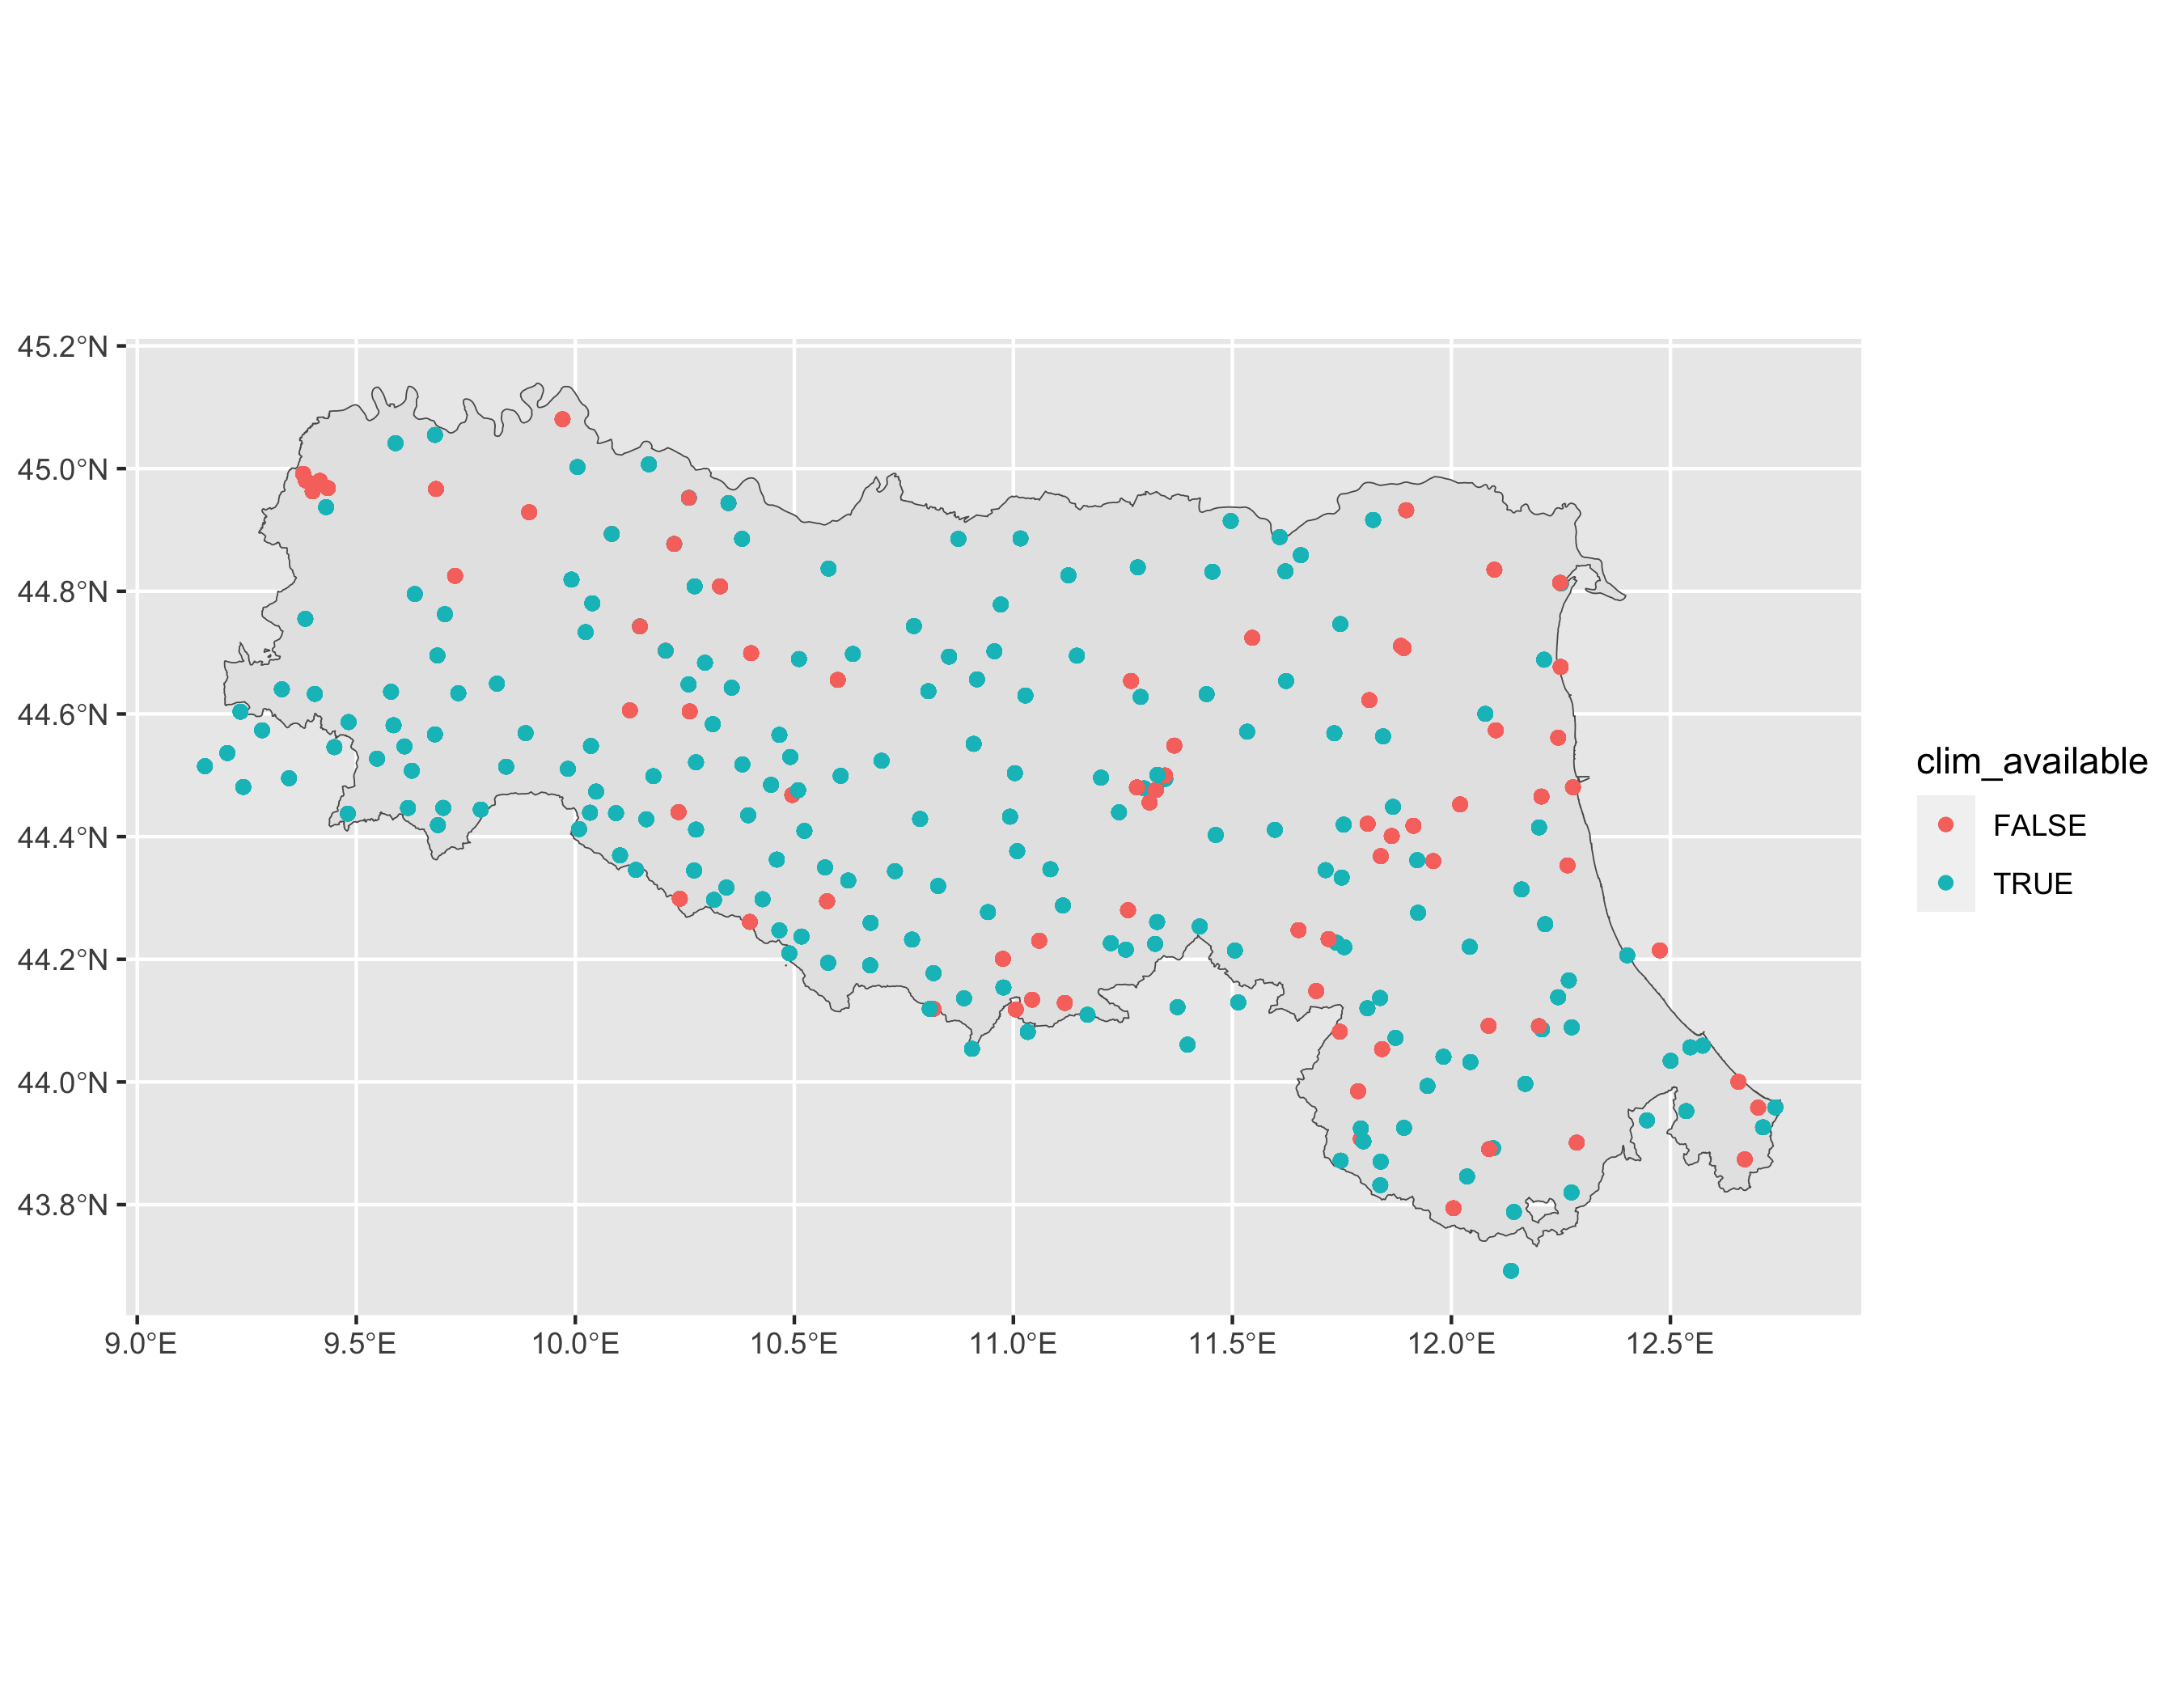

In [52]:
ggplot() +
    geom_sf(data = er.boundaries) +
    geom_sf(data = climats_comp, aes(color = clim_available))


## Merging
Gap-filling con SCIA

In [7]:
er.meta <- join_metas(stations_table, series_table)
scia.meta <- join_metas(scia_station_meta, scia_series_meta)


In [8]:
source("src/pairing/analysis.R")
matches <- match_table(er.meta, scia.meta, dist_km = 4)
c(er.table, scia.table) %<-% widen_split_data(data, scia_data, matches, first_date, last_date)
analysis <- analyze_matches(matches, er.table, scia.table, er.meta, scia.meta)


In [9]:
hard_filters <- function(data) {
    # Based on manual checks
    data |> mutate(
        hard_filter = abs(delT) <= 0.4
    )
}

sure_filters <- function(data) {
    data |> mutate(
        sure_match = (
            (distance <= 100 & (is.na(delH) | delH <= 50)) |
                (distance < 50) |
                (f0 >= 0.3 & valid_days_inters * f0 > 100) |
                (f0 >= 0.07 & abs(delT) <= 0.45)
        )
    )
}

very_good_filters <- function(data) {
    # Very good matches
    data |> mutate(
        very_good_match = (distance <= 500 & delH <= 100) & (f0 > 0.05 & valid_days_inters * f0 >= 30) & (abs(monthlydelT) <= 0.4)
    )
}


results.1 <- analysis |>
    hard_filters() |>
    sure_filters() |>
    very_good_filters()

# Sure matches. I take these as given and remove them from the match list. Some of them are duplicated both in scia and dpc; in any case I remove them from the master list as a whole.
sure_matches <- results.1 |>
    filter(sure_match)
sure_matches.by_same_station <- results.1 |>
    semi_join(sure_matches, by = join_by(series_id.x, series_id.y), na_matches = "never") |>
    anti_join(sure_matches, by = c("variable", "series_id.x", "series_id.y"))

# Surely match and respect hard filters
matchlist <- bind_rows(sure_matches, sure_matches.by_same_station) |> filter(hard_filter)

results.unsure <- results.1 |>
    clean_from(matchlist) |>
    filter(hard_filter)


In [162]:
source("src/pairing/combining.R")
upd <- update_left(matchlist, er.table, scia.table)

Warning message in predict.lm(model, ts):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"
Warning message in predict.lm(model, ts):
"prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases"


In [168]:
upd |> mutate(merged_from = merged_from[[1]]) |> as_arrow_table()

ERROR: [1m[33mError[39m in `mutate()`:[22m
[1m[22m[36mi[39m In argument: `merged_from = merged_from[[1]]`.
[1mCaused by error:[22m
[1m[22m[33m![39m `merged_from` must be size 2769399 or 1, not 2.


In [59]:
source("src/pairing/combining.R")
# c(data.merged, meta.merged) 
allta %<-% merged_tables(
    upd,
    data,
    scia_data,
    series_table,
    scia_series_meta |> semi_join(scia.meta |> filter(state == "Emilia-Romagna"), by = "series_id"),
    results.1 |> filter(sure_match)
)


In [12]:
allta

[[1]]
Table
2769399 rows x 4 columns
$series_id <string>
$date <date32[day]>
$value <float>
$merged <bool>

[[2]]
FileSystemDataset (query)
series_id: string
date: date32[day]
value: float
merged: bool

See $.data for the source Arrow object

[[3]]
FileSystemDataset (query)
series_id: string
date: date32[day]
value: float
merged: bool

See $.data for the source Arrow object

[[4]]
# A tibble: 435 x 5
   merged_from      series_id                        station_id variable qc_step
   <list>           <chr>                            <chr>      <chr>      <int>
 1 <named list [2]> 9d33c64eaee771ed0a07dd7c4af1221c 6963f92e4~ T_MAX          2
 2 <named list [2]> e9c15e29197665a0316f89a4a341e260 50398dde7~ T_MIN          2
 3 <named list [2]> 2b25d0fa43326279b20374e73467180e 387d9c34b~ T_MAX          2
 4 <named list [3]> 30248a9c7d9bba25bc6a2e50246ea068 aee7a0b91~ T_MIN          2
 5 <named list [2]> 471061221d9135caba980758ab421078 2677db2dc~ T_MIN          2
 6 <named list [2]> f9e8a433e

In [160]:
allta[[4]] |> as_arrow_table()

Table
435 rows x 5 columns
$merged_from: list<item: list<item <string>>>
$series_id <string>
$station_id <string>
$variable <string>
$qc_step <int32>

In [159]:
list_of(utf8())

ListType
list<item: string>

In [14]:
series_schema

Schema
series_id: string
station_id: string
variable: string
qc_step: uint8
merged_from: list<item: string>

In [15]:
select(allta[[4]], all_of(series_schema$names)) |> colnames()

[1] "series_id"   "station_id"  "variable"    "qc_step"     "merged_from"

In [125]:
allta[[4]] |> as_tibble() |> select(all_of(series_schema$names)) |> as_arrow_table()

Table
435 rows x 5 columns
$series_id <string>
$station_id <string>
$variable <string>
$qc_step <int32>
$merged_from: list<item: list<item <string>>>

In [83]:
mm <- upd |> pull(merged_from)

In [75]:
class(pull(upd, merged))

[1] "logical"

In [93]:
mm[1]

[[1]]
[1] "00731954219815c6d7a90810000c3adb" "3bac96b76d68ee033a6cb60a52252a73"

In [31]:
mm <- upd |> pull(merged)

In [52]:
df <- tibble(a = seq(1, 5), g = c("a", "a", "b", "b", "b"))

In [58]:
pr_sum <- function(dt) {
    summarise(dt, s = sum(a), h = cur_group() |> pull(1))
}

df |> group_by(g) |> pr_sum() |> print()

# A tibble: 2 x 3
  g         s h    
  <chr> <int> <chr>
1 a         3 a    
2 b        12 b    


In [94]:
upd |> as_arrow_table()

Table
2769399 rows x 5 columns
$series_id.x <string>
$value <double>
$date <date32[day]>
$merged <bool>
$merged_from: list<item <string>>

In [120]:
dtype$type

ListType
list<item: string>

In [149]:
df1 <- tibble(a = list(c("a", "b")), b = seq(1,3))

In [156]:
df1 |> as_arrow_table()

Table
3 rows x 2 columns
$a: list<item <string>>
$b <int32>

In [115]:
dtype <- (df1 |> as_arrow_table())$schema$field(0)

In [104]:
(series_table |> collect() |> pull(merged_from))[[1]]

[1] NA